# Model training notebook

### Import the important packages

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from scikeras.wrappers import KerasRegressor

import joblib

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Import the data

In [6]:
df_data = pd.read_csv("main_data.csv")
df_data.head()

,Cohesion,Phi,Unit_weight,Pe,Ps,FSs,FSgmp,slope_angle,slope_height
0,9.25214,27.0344,16.2721,25.7109,65.1980,1.97695,2.01425,60.0,15.0
1,12.84510,13.9206,16.3404,17.2906,61.5234,1.22958,1.25297,60.0,15.0
2,10.36260,30.1019,15.2261,89.1311,43.9082,1.55863,1.56072,60.0,15.0
3,8.00854,27.3663,14.5454,81.8012,59.8084,1.62134,1.62115,60.0,15.0
4,12.31330,40.8389,19.4886,75.3521,66.4819,2.57291,2.57134,60.0,15.0


#### Creating <b>x_data</b> and <b>y_data</b>

In [7]:
x_data_1    = df_data.iloc[:,[0,1,2,3,4,7,8]]
y_data_1    = df_data.iloc[:,[5,6]]


#### Selecting just $FS < 3$, because just in this range the predictions are important as adviced by engineers

In [8]:
x_data_1    = x_data_1[y_data_1.iloc[:,0] < 3]
y_data_1    = y_data_1[y_data_1.iloc[:,0] < 3]

#### Definition of Tensorflow ANN Pipeline

In [83]:
# Define input as X and output as Y


X_train, X_test, y_train, y_test = train_test_split(x_data_1,y_data_1.iloc[:,0], test_size=0.3, random_state=42)

# Function to create keras neural network and use it in scikeras wrapper

def create_model(optimizer = "RMSprop", drop_rate = 0.1, neurons = 10, l1 = 0.01, l2 =0.01):
 # create model
    model = Sequential()

    model.add(Dense(neurons,input_dim = 7, activation="relu",kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)))
    model.add(Dropout(drop_rate))
    model.add(Dense(neurons, activation="relu"))
    model.add(Dropout(drop_rate))
    model.add(Dense(neurons, activation='relu'))

    model.add(Dense(1))

    # Compile model
    model.compile(loss= "MSE", optimizer= optimizer, metrics=['MAPE'])
    return model


# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
callback = EarlyStopping(monitor='loss', patience=5)

# Definition of the keras wrapper model with callback for early stop
Ann_regressor = KerasRegressor(model=create_model, verbose=0, callbacks=[callback])

# Definition of pipeline
Reg_pipeline = Pipeline([
                        ("scale", StandardScaler()),
                        ("Regressor", Ann_regressor)])

#### Using pipeline to hyperparameter optimization using <b>SearchGridCV</b>

In [84]:
batch_size = [20]
epochs = [100]
optimizer = ["RMSprop"]
validation_split = [0.3]
neurons = [64]
drop_rate = [0.1]
l1l2 = [0.02]

# Definition of input for grid_search in dictionary format

param_grid = dict(Regressor__batch_size=batch_size,
                  Regressor__epochs=epochs,
                  Regressor__optimizer = optimizer,
                  Regressor__model__drop_rate = drop_rate,
                  Regressor__model__neurons = neurons,
                  Regressor__model__l1 = l1l2,
                  Regressor__model__l2 = l1l2,
                  Regressor__validation_split = validation_split)

# Grid creation
grid = GridSearchCV(estimator=Reg_pipeline, param_grid=param_grid, n_jobs=4, cv=5)


#### <b>Model.fit()<b>

In [85]:
modelb1 = grid.fit(X_train, y_train)

#### Review the results from <b>SearchGridCV</b>

In [86]:
pd.DataFrame(modelb1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Regressor__batch_size,param_Regressor__epochs,param_Regressor__model__drop_rate,param_Regressor__model__l1,param_Regressor__model__l2,param_Regressor__model__neurons,...,param_Regressor__validation_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,289.259847,92.7114,1.387913,0.307576,20,100,0.1,0.02,0.02,64,...,0.3,"{'Regressor__batch_size': 20, 'Regressor__epoc...",0.737631,0.88396,0.914712,0.872095,0.91678,0.865036,0.066008,1


#### Calculate $R^2$ and plot <b>y_train</b> $vs$ <b>y_pred</b>

0.9807622582571407


[Text(0.5, 0, '$y_{test}$'), Text(0, 0.5, 'y_{pred}')]

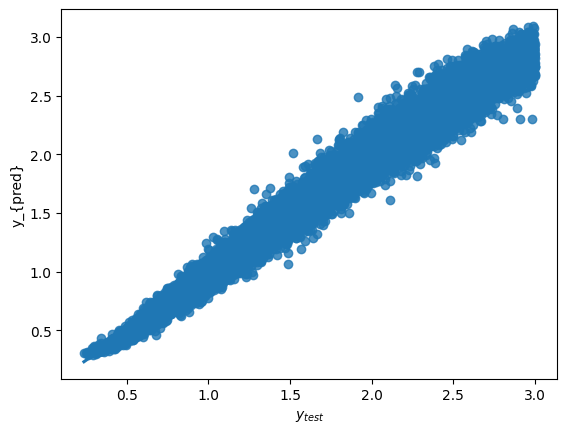

In [75]:
from sklearn.metrics import r2_score
print(r2_score(y_test,modelb1.best_estimator_.predict(X_test)))
ax = sns.regplot(x = y_test , y = modelb1.best_estimator_.predict(X_test))
ax.set(xlabel = r"$y_{test}$", ylabel = r"y_{pred}")

#### Save the best model from grid

In [87]:
joblib.dump(modelb1.best_estimator_, "Ann_model_slopes")


INFO:tensorflow:Assets written to: C:\Users\fbrow\AppData\Local\Temp\tmpwhtw1t7s\assets


INFO:tensorflow:Assets written to: C:\Users\fbrow\AppData\Local\Temp\tmpwhtw1t7s\assets


['Ann_model_slopes']

#### Try Xgboost model for regression with polynomial features

In [11]:
import xgboost as xgb


X_train, X_test , y_train, y_test = train_test_split(x_data_1,y_data_1.iloc[:,0], test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.3, random_state=42)


Reg_pipeline = Pipeline([
                        ("scale1", StandardScaler()),
                        ("scale2", PolynomialFeatures(degree=2)),
                        ("Regressor", xgb.XGBRegressor(booster="gblinear"))])


# model = Reg_pipeline.fit(X,Y["beta1"])
param_grid = {"Regressor__n_estimators":[800],
              "Regressor__reg_alpha" : [0.01],
              "Regressor__reg_lambda" : [0.03],
              "Regressor__eval_metric" : ["rmse"],
            #   "Regressor__max_depth" : [3],
              "Regressor__eta" : [0.3],
              "Regressor__seed" : [0]}

# Grid creation
grid = GridSearchCV(estimator=Reg_pipeline, param_grid=param_grid, n_jobs=5, cv=5)
# grid = RandomizedSearchCV(estimator=Reg_pipeline, param_distributions=param_grid, n_jobs=5, cv=5, n_iter=1)


#### Xgboost <b>grid.fit()</b>

In [12]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale1', StandardScaler()),
                                       ('scale2', PolynomialFeatures()),
                                       ('Regressor',
                                        XGBRegressor(base_score=None,
                                                     booster='gblinear',
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gam...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=5,
             param_grid={'Regressor__eta': [0.3],
                         'Regressor__eval_metric': ['rmse'],
                         'Regressor__n_estimators': [800],
                         'Regressor__reg_alpha': [0.01],
                         'Regressor__reg_lambda': [0.03],
                         'Regressor__seed': [0]})

Inspect the results obtained from grid

In [16]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Regressor__eta,param_Regressor__eval_metric,param_Regressor__n_estimators,param_Regressor__reg_alpha,param_Regressor__reg_lambda,param_Regressor__seed,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,44.220749,0.521204,0.055407,0.002063,0.3,rmse,800,0.01,0.03,0,"{'Regressor__eta': 0.3, 'Regressor__eval_metri...",0.947867,0.946293,0.947661,0.949117,0.944714,0.94713,0.001504,1


ExactExplainer explainer: 50193it [17:54, 46.37it/s]                           


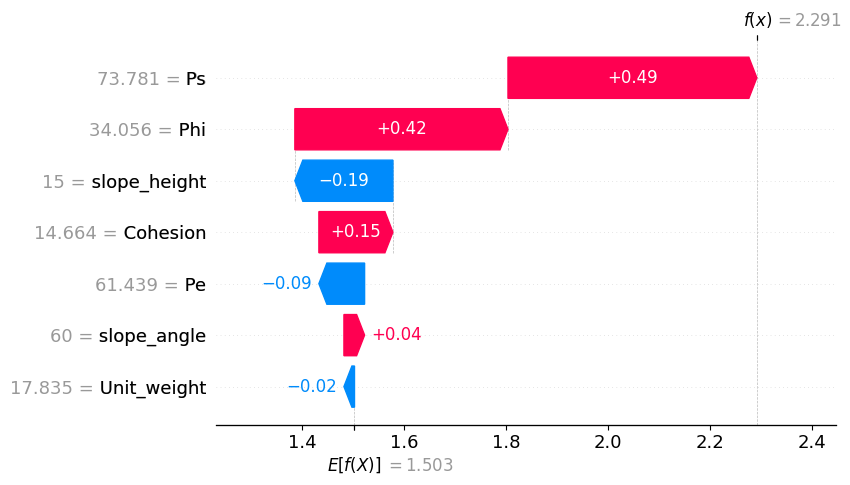

In [13]:
X100 = shap.utils.sample(x_data_1, 100)
explainer = shap.Explainer(grid.best_estimator_.predict, X100)
shap_values = explainer(x_data_1)
shap.plots.waterfall(shap_values[20], max_display=14)


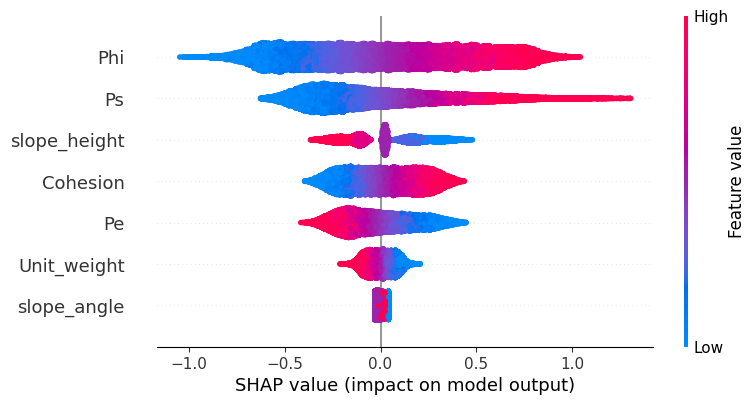

In [14]:
shap.plots.beeswarm(shap_values)


Calculate the $R^2$ value between <b>y_test</b> and <b>y_pred</b>

 Rsquared value is 0.9358028263036899


[Text(0.5, 0, '$y_{test}$'), Text(0, 0.5, '$y_{pred}$')]

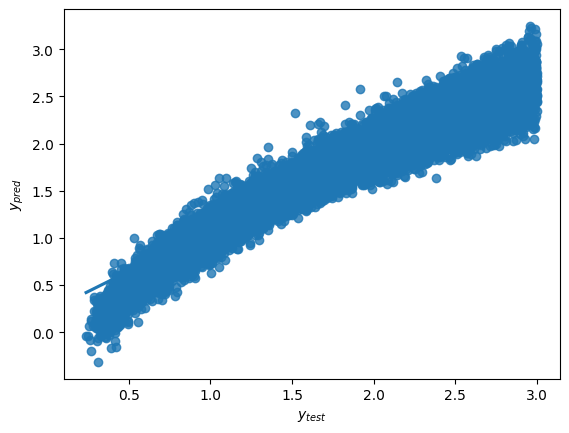

In [42]:
print(" Rsquared value is " + f'{r2_score(y_test,grid.best_estimator_.predict(X_test))}')
ax = sns.regplot(x = y_test, y = grid.best_estimator_.predict(X_test))
ax.set(xlabel = r"$y_{test}$", ylabel = r"$y_{pred}$")


#### Save the XGboost model using <b>joblib</b>

In [46]:
joblib.dump(grid.best_estimator_, "xgboost_reg")

['xgboost_reg']

In [ ]:
rgb_model = joblib.load("xgboost_reg")

#### Test the models with a random example to inspect the difference between them

In [88]:
te_st = pd.DataFrame(np.array([[0,30,17,30,0,90,15]]), columns= list(x_data_1.columns))

model = joblib.load("Ann_model_slopes")
rgb_model = joblib.load("xgboost_reg")

print(rgb_model.predict(te_st), model.predict(te_st))

[0.61946136] [0.7787737]


Establishing an optimization process to calculate $P_{s}$ by establishing a $FS$ objective of 1.5

In [65]:
def obj_func(x):
    te_st = pd.DataFrame(np.array([[0,30,17,50,x[0],75,10]]), columns= list(x_data_1.columns))
    return abs(rgb_model.predict(te_st)-1.5)

x0 = [35]
bds = [(30,50)]


from mystic.solvers import diffev2
from mystic.math import almostEqual
from mystic.monitors import VerboseMonitor
mon = VerboseMonitor(10)

result = diffev2(obj_func, x0=bds, npop=40,  gtol=30, disp=False, full_output=True, itermon=mon)

Generation 0 has ChiSquare: 0.0003556013
Generation 10 has ChiSquare: 5.9604645e-06
Generation 20 has ChiSquare: 1.1920929e-07
Generation 30 has ChiSquare: 0.0
STOP("ChangeOverGeneration with {'tolerance': 0.005, 'generations': 30}")


In [69]:
x = result[0]
te_st =  pd.DataFrame(np.array([[0,30,17,50,x[0],75,10]]), columns= list(x_data_1.columns))
model.predict(te_st)

print("The pressure needed for equilibrium is: " f'{result[0]}',"With a FS obj of:" f'{rgb_model.predict(te_st),model.predict(te_st)}')

The pressure needed for equilibrium is: [45.67362749] With a FS obj of:(array([1.5], dtype=float32), array([1.7116208], dtype=float32))
